# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libaries</p>

In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, Dot, Lambda

2024-02-17 07:30:53.276402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 07:30:53.276538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 07:30:53.576124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Reading Data</p>

In [2]:
from tqdm.notebook import tqdm
# Read data from text
with open('/kaggle/input/mit-plagairism-detection-dataset/train_snli.txt') as file:
    data = file.readlines()
    
# prepare csv file
with open('data.csv', 'w', newline= '') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)
    
    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        source_txt = parts[0]
        plagiarishm_txt = parts[1]
        label = int(parts[2])
        
        writer.writerow({
            'source_txt' : source_txt,
            'plagiarism_txt' : plagiarishm_txt,
            'label' : label
        })
print('CSV file created successfully...')

  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


In [3]:
df = pd.read_csv('/kaggle/working/data.csv')

In [4]:
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [5]:
df.shape

(367373, 3)

In [6]:
df.isnull().sum()

source_txt        0
plagiarism_txt    4
label             0
dtype: int64

In [7]:
df.duplicated().sum()

454

In [8]:
df.dropna(inplace=True)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.shape)

source_txt        0
plagiarism_txt    0
label             0
dtype: int64
0
(366915, 3)


<Axes: xlabel='label'>

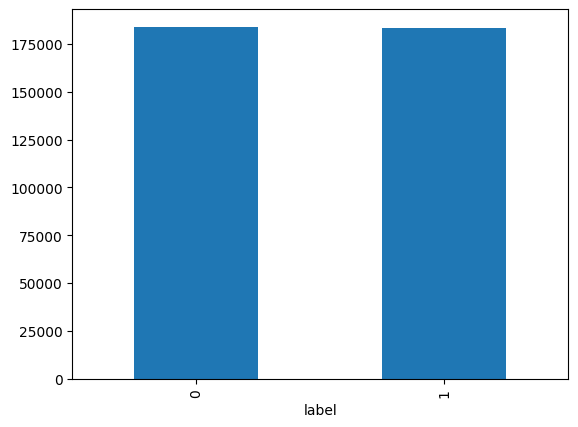

In [11]:
df['label'].value_counts().plot(kind='bar')

In [12]:
print(df['source_txt'][1])
print(df['plagiarism_txt'][1])

A person on a horse jumps over a broken down airplane.
A person is outdoors, on a horse.


# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Preprocesing data</p>

In [13]:
import string

def preprocess_text(text):
    if isinstance(text, str):
        # Remove punctuation
        text = text.translate(str.maketrans("", "", string.punctuation))
        # Convert to lowercase
        text = text.lower()
    return text


In [14]:
df['source_txt'] = df['source_txt'].apply(preprocess_text)
df['plagiarism_txt'] = df['plagiarism_txt'].apply(preprocess_text)

In [15]:
df['source_txt'][1]

'a person on a horse jumps over a broken down airplane'

# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Tokenization</p>

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['source_txt'] + '' + df['plagiarism_txt'])
X = tokenizer.texts_to_sequences(df['source_txt'] + '' + df['plagiarism_txt'])
X = pad_sequences(X)

In [17]:
y = df['label']

In [18]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)

# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Build The Model</p>

In [19]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = X.shape[1]),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 111, 100)          7534900   
                                                                 
 lstm (LSTM)                 (None, 111, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 7701621 (29.38 MB)
Trainable params: 7701621 (29.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Train The Model</p>

In [20]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 6: Train the model
model.fit(xtrain, ytrain, batch_size=64, epochs=1, validation_data=[xtest, ytest], callbacks=callback)


4587/4587 [==============================] - 2820s 613ms/step - loss: 0.2351 - accuracy: 0.9025 - val_loss: 0.4168 - val_accuracy: 0.8260


# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Evaluate The Model</p>

# <p style="background-image: url(https://img.freepik.com/premium-photo/cyber-big-data-flow-blockchain-data-fields-network-line-connect-stream-concept-ai-technology_647611-168.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699315200&semt=aisg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Creating  A System To Predict Input Text</p>

In [33]:
import pickle
model.save('model.h5')
with open('tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer, file)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your model
model = load_model('/kaggle/working/model.h5')

# Quantize the model
quantized_model = tf.keras.models.clone_model(model)
quantized_model.set_weights(model.get_weights())
quantized_model.compile(optimizer=model.optimizer, loss=model.loss)

# Save the quantized model
quantized_model.save('quantized_model.h5')


In [38]:
def pre_text(text):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen = 111)
    return padded_sequences
def prdict_plagiarism(text):
    process_text = pre_text(text)
    predictions = model.predict(process_text)
    return predictions[0][0]

new_text = "a few people in a restaurant setting one of them is drinking orange juice"
predictions = prdict_plagiarism(new_text)
if predictions >  .5 :
    
    print('This Text Has Plagiarism With Similarity Score IS:  ', predictions)
else:
    print("This Text Has No Plagiarism")

1/1 [==============================] - 0s 74ms/step
This Text Has No Plagiarism


In [31]:
df['plagiarism_txt'][50]

'two adults walk across a street'

In [70]:
print(df['source_txt'][10])
print(df['plagiarism_txt'][10])

a few people in a restaurant setting one of them is drinking orange juice
the diners are at a restaurant
